In [1]:
# normalize all routes for a player in a game against the same LOS
# but first map all routes directionally for a team in a game

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
import math
from matplotlib.patches import Rectangle
from textwrap import wrap

"""
master_input.parquet
master_output.parquet
play_level.parquet
player_analysis.parquet
spatial_features.parquet
supplementary.parquet
trajectories.parquet
"""
base_dir = "../consolidated_data/"

In [3]:
play_keys = ['game_id', 'play_id']
player_keys = play_keys + ['nfl_id']
player_dtls = ['player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'num_frames_output']
player_mvmt = ['frame_id', 'x', 'y']

# field extents
ymin = 0
ymax = 53.3

xmin = 0
xmax = 120

input_cols = player_keys + player_dtls + player_mvmt + ['player_to_predict', 'play_direction', 'absolute_yardline_number', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'week']
input_df = pd.read_parquet(f'{base_dir}/master_input.parquet')
supp_df = pd.read_parquet(f'{base_dir}/supplementary.parquet')

output_cols = player_keys + player_mvmt
output_df = pd.read_parquet(f'{base_dir}/master_output.parquet')

igame_df = pd.merge(input_df, supp_df, on=['game_id', 'play_id'], how='left')

In [51]:
# Helper Functions
def flipx(Series):
    diff = (xmax / 2) - Series['x']
    return (xmax / 2) + diff

def flipy(Series):
    diff = (ymax / 2) - Series['y']
    return (ymax / 2) + diff

def normalize_losx(Series):
    losx = 30
    diff = Series['start_x'] - losx
    return Series['x'] - diff

def normalize_losy(Series):
    losy = ymax / 2
    diff = Series['y'] - Series['passer_y']
    return losy + diff

In [76]:
# igame_df.query("game_id == 2023092501 and player_side == 'Offense' and possession_team == 'CIN' and player_role == 'Targeted Receiver'")[['play_id', 'quarter', 'game_clock', 'yards_gained', 'player_name', 'route_of_targeted_receiver']].drop_duplicates()
input_df.columns

Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'week'],
      dtype='object')

In [77]:
# 464 - unique receivers
# 53434 Ja'Marr Chase
# 52409 Joe Burrow
igame_df.query("player_role == 'Targeted Receiver' and possession_team == 'CIN'")[['nfl_id', 'player_name']].drop_duplicates()

,nfl_id,player_name
51356,53434,Ja'Marr Chase
52050,47833,Irv Smith
52661,43344,Tyler Boyd
54184,44860,Joe Mixon
55220,52441,Tee Higgins
65938,53631,Chris Evans
340495,47965,Trayveon Williams
851033,55996,Charlie Jones
851578,46797,Tanner Hudson
853040,52673,Mitchell Wilcox


In [49]:
# igame_df[igame_df.nfl_id == 52409].query('game_id == 2023092501 and frame_id == 1')[['frame_id', 'x', 'y']]
game_df = igame_df.loc[igame_df['game_id'] == 2023092501]
passer_position = game_df[((game_df['player_role'] == 'Passer') & (game_df['frame_id'] == 1))][['game_id', 'play_id', 'play_direction', 'x', 'y']]

passer_position.loc[passer_position['play_direction'] == 'left', ['x']] = passer_position.apply(flipx, axis=1)
passer_position.loc[passer_position['play_direction'] == 'left', ['y']] = passer_position.apply(flipy, axis=1)

passer_position = passer_position.rename(columns={'x': 'passer_x', 'y': 'passer_y'})
passer_position

,game_id,play_id,play_direction,passer_x,passer_y
850496,2023092501,79,right,29.91,23.68
850763,2023092501,109,right,38.53,29.71
851014,2023092501,156,right,54.95,29.71
851294,2023092501,181,right,61.04,29.67
851558,2023092501,238,right,67.55,29.72
...,...,...,...,...,...
870676,2023092501,4117,right,58.37,24.53
870997,2023092501,4153,right,65.51,29.91
871379,2023092501,4176,right,65.53,29.90
871793,2023092501,4241,right,64.77,29.89


In [92]:
receiver_id = [53434]
player_df = game_df.loc[game_df['nfl_id'].isin(receiver_id)]#.query('yards_to_go > 8') # and play_id == 79')

# Normalize direction of play from left to right:
player_df.loc[player_df['play_direction'] == 'left', ['x']] = player_df.apply(flipx, axis=1)
player_df.loc[player_df['play_direction'] == 'left', ['y']] = player_df.apply(flipy, axis=1)

# Normalize play to same LOS
init1_df = player_df.loc[player_df['frame_id'] == 1, ['game_id', 'play_id', 'nfl_id', 'x', 'y']].rename(columns={'x': 'start_x', 'y': 'start_y'})
init2_df = pd.merge(player_df, init1_df, on=['game_id', 'play_id', 'nfl_id'], how='left')

# init2_df.loc[:, ['x']] = init2_df.apply(normalize_losx, axis=1)
init2_df.loc[:, ['game_play_id']] = init2_df.apply(lambda s: s['game_id'] + s['play_id'], axis=1)

# Normalize distance from QB
init4_df = pd.merge(init2_df, passer_position, on=['game_id', 'play_id'], how='left')

init4_df.loc[:, ['x']] = init4_df.apply(normalize_losx, axis=1)
init4_df.loc[:, ['y']] = init4_df.apply(normalize_losy, axis=1)
init4_df.loc[:, ['game_play_id']] = init4_df.apply(lambda s: s['game_id'] + s['play_id'], axis=1)

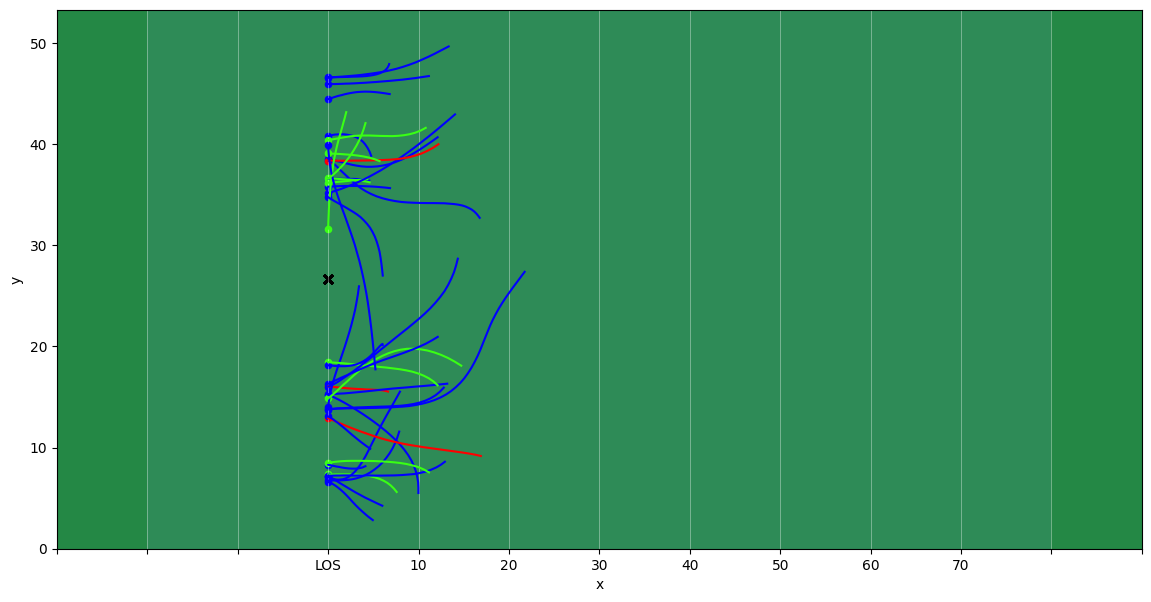

In [93]:
plot_df = init4_df

fig, ax = plt.subplots(figsize=(14,7))

# Configure chart
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax])

# title = "\n".join(wrap(s_df['play_description'].iloc[0], 100))
# ax.set_title(f"{title}")
ax.set_facecolor('#2E8B57')

# add field markings
for yard in range(10, 111, 10):
    ax.axvline(x=yard, color='white', linestyle='-', linewidth=0.5, alpha=0.5)

ax.set_xticks(
    ticks=[x for x in range(0, 130, 10)], 
    labels=['', '', '', 'LOS', 10, 20, 30, 40, 50, 60, 70, '', '']
)

# add end zones
ax.add_patch(Rectangle((0, 0), 10, 53.3, facecolor='green', alpha=0.2))
ax.add_patch(Rectangle((110, 0), 10, 53.3, facecolor='green', alpha=0.2))
fmt = {
    "Other Route Runner": {"C": ['blue', '-'], "I": ['blue', '-'], "IN": ['blue', '-']},
    "Targeted Receiver": {"C": ['#39FF14', '-'], "I": ['red', '-'], "IN": ['purple', '-']}
}

for play_id, p_df in plot_df.groupby('game_play_id'):
    ax.scatter((30),(26.65), 
        color='black',
        marker='x'
    )
    p_df.query('frame_id == 1').plot(
        x='x',
        y='y', 
        kind='scatter',
        color=fmt[p_df['player_role'].iloc[0]][p_df['pass_result'].iloc[0]][0],
        marker='o',
        ax=ax
    )
    p_df[['play_id', 'x', 'y']].plot(
        x='x', 
        y='y', 
        color=fmt[p_df['player_role'].iloc[0]][p_df['pass_result'].iloc[0]][0],
        kind='line', 
        ax=ax
    )

ax.get_legend().remove()